In [238]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

In [239]:
data = pd.read_csv("./data/merged_data.csv").drop(columns=['Unnamed: 0'])
data.head()

,track_id,genre,title,chroma_cens1,chroma_cens2,chroma_cens3,chroma_cens4,chroma_cens5,chroma_cens6,chroma_cens7,...,spectral_contrast6,spectral_contrast7,spectral_rolloff1,tonnetz1,tonnetz2,tonnetz3,tonnetz4,tonnetz5,tonnetz6,zcr1
0,135054,Experimental,Hari Karl (for Larry Eisenberg),0.310373,0.308683,0.290821,0.297749,0.287629,0.260195,0.229743,...,17.265811,42.597892,2571.502445,-0.002862,-0.000695,0.004706,-0.006419,0.005246,-0.001563,0.070002
1,135336,Pop,Slow and Steady,0.161290,0.161296,0.190398,0.171992,0.189878,0.187176,0.231823,...,20.103589,33.081974,4486.854020,-0.006867,-0.004326,-0.092237,0.019405,-0.006026,0.015697,0.085219
2,135337,Pop,The Dream and the Dreamer,0.443386,0.357355,0.191626,0.202726,0.284854,0.236113,0.234724,...,21.580315,32.187206,4382.598041,0.024635,-0.007949,0.011779,0.130071,0.014134,0.009135,0.108170
3,135043,Folk,Babel,0.141946,0.153972,0.169128,0.218597,0.385648,0.400918,0.308826,...,21.147088,32.537513,4162.319868,0.017150,-0.001607,-0.063755,0.005411,0.006720,-0.011991,0.074080
4,135091,Experimental,Tree and Wind,0.017648,0.017463,0.035690,0.158926,0.163426,0.064951,0.212070,...,19.401185,34.605480,4653.557040,-0.002268,-0.042291,0.160464,-0.144974,0.053375,-0.030622,0.100463


In [240]:
data.columns

Index(['track_id', 'genre', 'title', 'chroma_cens1', 'chroma_cens2',
       'chroma_cens3', 'chroma_cens4', 'chroma_cens5', 'chroma_cens6',
       'chroma_cens7', 'chroma_cens8', 'chroma_cens9', 'chroma_cens10',
       'chroma_cens11', 'chroma_cens12', 'chroma_cqt1', 'chroma_cqt2',
       'chroma_cqt3', 'chroma_cqt4', 'chroma_cqt5', 'chroma_cqt6',
       'chroma_cqt7', 'chroma_cqt8', 'chroma_cqt9', 'chroma_cqt10',
       'chroma_cqt11', 'chroma_cqt12', 'chroma_stft1', 'chroma_stft2',
       'chroma_stft3', 'chroma_stft4', 'chroma_stft5', 'chroma_stft6',
       'chroma_stft7', 'chroma_stft8', 'chroma_stft9', 'chroma_stft10',
       'chroma_stft11', 'chroma_stft12', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4',
       'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11',
       'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18',
       'mfcc19', 'mfcc20', 'rmse1', 'spectral_bandwidth1',
       'spectral_centroid1', 'spectral_contrast1', 'spectral_contrast2',
       'sp

In [241]:
data_new = data.drop(columns=['genre','title', 'track_id'])

In [242]:
data_new.columns

Index(['chroma_cens1', 'chroma_cens2', 'chroma_cens3', 'chroma_cens4',
       'chroma_cens5', 'chroma_cens6', 'chroma_cens7', 'chroma_cens8',
       'chroma_cens9', 'chroma_cens10', 'chroma_cens11', 'chroma_cens12',
       'chroma_cqt1', 'chroma_cqt2', 'chroma_cqt3', 'chroma_cqt4',
       'chroma_cqt5', 'chroma_cqt6', 'chroma_cqt7', 'chroma_cqt8',
       'chroma_cqt9', 'chroma_cqt10', 'chroma_cqt11', 'chroma_cqt12',
       'chroma_stft1', 'chroma_stft2', 'chroma_stft3', 'chroma_stft4',
       'chroma_stft5', 'chroma_stft6', 'chroma_stft7', 'chroma_stft8',
       'chroma_stft9', 'chroma_stft10', 'chroma_stft11', 'chroma_stft12',
       'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8',
       'mfcc9', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15',
       'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc20', 'rmse1',
       'spectral_bandwidth1', 'spectral_centroid1', 'spectral_contrast1',
       'spectral_contrast2', 'spectral_contrast3', 'spectral_contrast

In [243]:
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot
from numpy import unique
from numpy import where

In [244]:
data_new['chroma_cens_avg'] = data_new[['chroma_cens1', 'chroma_cens2', 'chroma_cens3', 'chroma_cens4',
       'chroma_cens5', 'chroma_cens6', 'chroma_cens7', 'chroma_cens8',
       'chroma_cens9', 'chroma_cens10', 'chroma_cens11', 'chroma_cens12']].mean(axis=1)

data_new = data_new.drop(columns=['chroma_cens1', 'chroma_cens2', 'chroma_cens3', 'chroma_cens4',
       'chroma_cens5', 'chroma_cens6', 'chroma_cens7', 'chroma_cens8',
       'chroma_cens9', 'chroma_cens10', 'chroma_cens11', 'chroma_cens12'])

data_new['chroma_cqt_avg'] = data_new[['chroma_cqt1', 'chroma_cqt2', 'chroma_cqt3', 'chroma_cqt4',
       'chroma_cqt5', 'chroma_cqt6', 'chroma_cqt7', 'chroma_cqt8',
       'chroma_cqt9', 'chroma_cqt10', 'chroma_cqt11', 'chroma_cqt12']].mean(axis=1)

data_new = data_new.drop(columns=['chroma_cqt1', 'chroma_cqt2', 'chroma_cqt3', 'chroma_cqt4',
       'chroma_cqt5', 'chroma_cqt6', 'chroma_cqt7', 'chroma_cqt8',
       'chroma_cqt9', 'chroma_cqt10', 'chroma_cqt11', 'chroma_cqt12'])

data_new['chroma_stft_avg'] = data_new[['chroma_stft1', 'chroma_stft2', 'chroma_stft3', 'chroma_stft4',
       'chroma_stft5', 'chroma_stft6', 'chroma_stft7', 'chroma_stft8',
       'chroma_stft9', 'chroma_stft10', 'chroma_stft11', 'chroma_stft12']].mean(axis=1)

data_new = data_new.drop(columns=['chroma_stft1', 'chroma_stft2', 'chroma_stft3', 'chroma_stft4',
       'chroma_stft5', 'chroma_stft6', 'chroma_stft7', 'chroma_stft8',
       'chroma_stft9', 'chroma_stft10', 'chroma_stft11', 'chroma_stft12'])

data_new['spectral_contrast_avg'] = data_new[['spectral_contrast1',
       'spectral_contrast2', 'spectral_contrast3', 'spectral_contrast4',
       'spectral_contrast5', 'spectral_contrast6', 'spectral_contrast7']].mean(axis=1)

data_new = data_new.drop(columns=['spectral_contrast1',
       'spectral_contrast2', 'spectral_contrast3', 'spectral_contrast4',
       'spectral_contrast5', 'spectral_contrast6', 'spectral_contrast7'])

data_new = data_new.drop(columns=['tonnetz1', 'tonnetz2', 'tonnetz3', 'tonnetz4',
       'tonnetz5', 'tonnetz6'])

In [245]:
data_new.head()

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,mfcc20,rmse1,spectral_bandwidth1,spectral_centroid1,spectral_rolloff1,zcr1,chroma_cens_avg,chroma_cqt_avg,chroma_stft_avg,spectral_contrast_avg
0,-284.673103,136.940830,-1.706287,46.987941,-4.991191,24.425244,-3.126049,12.865441,7.205975,-2.471064,...,-1.334874,1.968544,1389.195476,1270.517057,2571.502445,0.070002,0.271821,0.561447,0.497133,21.476695
1,-99.957216,100.856206,19.690323,22.063842,14.831470,5.936942,-1.968519,1.743159,-9.087388,-0.618997,...,3.010280,6.808776,2437.100979,2230.693570,4486.854020,0.085219,0.243045,0.445526,0.397641,21.229311
2,-110.618921,89.579104,-10.634255,-5.660547,-6.602311,-21.095758,-21.917632,-8.071590,-12.867615,-1.811076,...,1.296346,5.291817,2368.194239,2284.877592,4382.598041,0.108170,0.246168,0.455258,0.240365,22.715981
3,-140.360722,107.095759,14.577092,30.654562,7.088532,4.895010,11.492420,0.294665,-12.860315,13.068435,...,0.255368,3.660768,2367.205362,1969.056499,4162.319868,0.074080,0.253937,0.491335,0.338472,22.937072
4,-383.205631,34.632317,-49.995862,-47.216860,-53.404964,-42.121712,-21.026824,39.805068,31.422007,11.054475,...,5.466673,0.739969,2215.744376,2356.188217,4653.557040,0.100463,0.216975,0.362044,0.184751,23.291432


In [246]:
# # Partition dataset into attributes and class labels
# X = data_new.drop(['genre','title', 'track_id'], axis = 1)
# Y = data_new['genre']

In [247]:
from scipy.stats import pearsonr
import pandas as pd
# Function taken from: https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues

k = calculate_pvalues(data_new)
k.to_csv("\pearson_coeff.csv", index=False)
k

,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,...,mfcc20,rmse1,spectral_bandwidth1,spectral_centroid1,spectral_rolloff1,zcr1,chroma_cens_avg,chroma_cqt_avg,chroma_stft_avg,spectral_contrast_avg
mfcc1,0,0,0,0,0,0,0.0524,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mfcc2,0,0,0.0001,0,0,0,0.0118,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mfcc3,0,0.0001,0,0.0015,0,0,0,0,0,0,...,0,0.0062,0,0,0.4866,0,0,0,0,0
mfcc4,0,0,0.0015,0,0,0,0,0,0,0,...,0,0,0,0.1638,0.0679,0,0.5543,0.0762,0,0
mfcc5,0,0,0,0,0,0,0,0,0,0,...,0.0956,0,0.5421,0,0,0,0,0,0,0
mfcc6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
mfcc7,0.0524,0.0118,0,0,0,0,0,0,0,0,...,0,0,0,0,0.5225,0,0,0,0,0
mfcc8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.0033,0,0,0,0
mfcc9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.0028,0.0596,0,0
mfcc10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [206]:
data_new = data_new.drop(columns=['mfcc7', 'mfcc5', 'mfcc19', 'mfcc3', 'mfcc4'])

In [207]:
# Load libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn import metrics

In [208]:
# Factorize class labels
factor = pd.factorize(data['genre'])
print(factor[0])
data_new["genre_factorised"] = factor[0]

[0 1 1 ... 3 0 6]


[Text(0,0.5,'chroma_cqt_avg'),
 Text(0.5,0,'chroma_cens_avg'),
 Text(0.5,1,'data')]

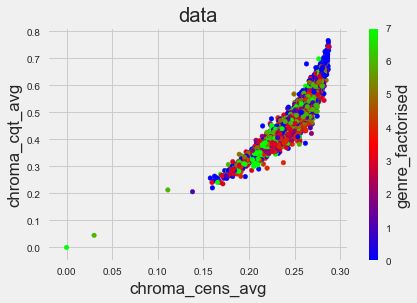

In [209]:
# Plot data
ax = data_new.plot(kind = 'scatter', x = 'chroma_cens_avg', y = 'chroma_cqt_avg', c = 'genre_factorised', colormap = plt.cm.brg)
ax.set(title = 'data', xlabel = 'chroma_cens_avg', ylabel = 'chroma_cqt_avg')

In [210]:
data_new.head()

,mfcc1,mfcc2,mfcc6,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,...,rmse1,spectral_bandwidth1,spectral_centroid1,spectral_rolloff1,zcr1,chroma_cens_avg,chroma_cqt_avg,chroma_stft_avg,spectral_contrast_avg,genre_factorised
0,-284.673103,136.940830,24.425244,12.865441,7.205975,-2.471064,9.460878,-5.984003,7.919311,-5.579881,...,1.968544,1389.195476,1270.517057,2571.502445,0.070002,0.271821,0.561447,0.497133,21.476695,0
1,-99.957216,100.856206,5.936942,1.743159,-9.087388,-0.618997,-6.614001,0.785494,-2.055657,-5.552616,...,6.808776,2437.100979,2230.693570,4486.854020,0.085219,0.243045,0.445526,0.397641,21.229311,1
2,-110.618921,89.579104,-21.095758,-8.071590,-12.867615,-1.811076,-5.459915,-1.675839,3.279005,-3.259410,...,5.291817,2368.194239,2284.877592,4382.598041,0.108170,0.246168,0.455258,0.240365,22.715981,1
3,-140.360722,107.095759,4.895010,0.294665,-12.860315,13.068435,-7.146124,2.789174,2.956712,3.124488,...,3.660768,2367.205362,1969.056499,4162.319868,0.074080,0.253937,0.491335,0.338472,22.937072,2
4,-383.205631,34.632317,-42.121712,39.805068,31.422007,11.054475,1.620559,0.774250,-13.686213,-10.400074,...,0.739969,2215.744376,2356.188217,4653.557040,0.100463,0.216975,0.362044,0.184751,23.291432,0


In [211]:
data.head()

,track_id,genre,title,chroma_cens1,chroma_cens2,chroma_cens3,chroma_cens4,chroma_cens5,chroma_cens6,chroma_cens7,...,spectral_contrast6,spectral_contrast7,spectral_rolloff1,tonnetz1,tonnetz2,tonnetz3,tonnetz4,tonnetz5,tonnetz6,zcr1
0,135054,Experimental,Hari Karl (for Larry Eisenberg),0.310373,0.308683,0.290821,0.297749,0.287629,0.260195,0.229743,...,17.265811,42.597892,2571.502445,-0.002862,-0.000695,0.004706,-0.006419,0.005246,-0.001563,0.070002
1,135336,Pop,Slow and Steady,0.161290,0.161296,0.190398,0.171992,0.189878,0.187176,0.231823,...,20.103589,33.081974,4486.854020,-0.006867,-0.004326,-0.092237,0.019405,-0.006026,0.015697,0.085219
2,135337,Pop,The Dream and the Dreamer,0.443386,0.357355,0.191626,0.202726,0.284854,0.236113,0.234724,...,21.580315,32.187206,4382.598041,0.024635,-0.007949,0.011779,0.130071,0.014134,0.009135,0.108170
3,135043,Folk,Babel,0.141946,0.153972,0.169128,0.218597,0.385648,0.400918,0.308826,...,21.147088,32.537513,4162.319868,0.017150,-0.001607,-0.063755,0.005411,0.006720,-0.011991,0.074080
4,135091,Experimental,Tree and Wind,0.017648,0.017463,0.035690,0.158926,0.163426,0.064951,0.212070,...,19.401185,34.605480,4653.557040,-0.002268,-0.042291,0.160464,-0.144974,0.053375,-0.030622,0.100463


In [212]:
# Partition dataset into attributes and class labels
X = data_new.drop(['genre_factorised'], axis = 1)
Y = data_new['genre_factorised']

In [213]:
 # CLUSTERING: Agglomerative clustering with single (min) linkage
clustering = linkage(X, method = "single", metric = "euclidean")

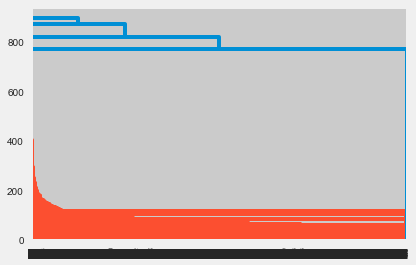

In [214]:
# Plot dendrogram
plt.figure()
dendrogram(clustering)
plt.show()

In [215]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [216]:
features, true_labels = make_blobs(
        n_samples=200,
        centers=3,
        cluster_std=2.75,
        random_state=42
    )

In [217]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

In [218]:
kmeans = KMeans(
        init="random",
        n_clusters=8,
        n_init=10,
        max_iter=300,
        random_state=42
    )

In [219]:
kmeans.fit(scaled_features)

KMeans(init='random', random_state=42)

In [220]:
kmeans.inertia_

105727.84128343116

In [221]:
kmeans.cluster_centers_

array([[ 0.39524273, -0.6503433 ,  0.7547461 ,  0.94606538,  0.81214093,
         0.95141884,  0.9195546 ,  0.98850053,  1.00374419,  1.08991002,
         0.9701508 ,  1.00785364,  0.85449786,  0.89292257,  0.81156174,
         0.71257751,  0.75622811,  0.47895469,  0.64937588, -0.20060484,
        -0.28536805, -0.24934266,  1.07077683, -0.67786754],
       [ 0.52775625, -0.18388095,  0.2412505 ,  0.36808401,  0.18381084,
         0.3414423 ,  0.22364709,  0.3391098 ,  0.15575119,  0.28904938,
         0.14257443,  0.31419202,  0.0307057 ,  0.22885082,  0.18241757,
         0.26626252,  0.36592096,  0.22009588,  0.28953922,  0.07312278,
         0.61311875,  0.60320991,  0.33572718, -0.53510775],
       [-1.22403287,  1.4304642 , -0.47662451, -0.55690668, -0.03909985,
        -0.70860209, -0.14604852, -0.5737627 , -0.04685269, -0.62363781,
        -0.09788481, -0.6321895 , -0.011795  , -0.63991716, -0.64293279,
        -0.64152517, -1.54207974, -1.34530433, -1.40750184, -0.84814074,
  

In [222]:
kmeans.n_iter_

90

In [223]:
kmeans.labels_[:]

array([7, 1, 4, ..., 6, 6, 1], dtype=int32)

In [227]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

# A list holds the SSE values for each k
sse = []
for k in range(1, 9):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

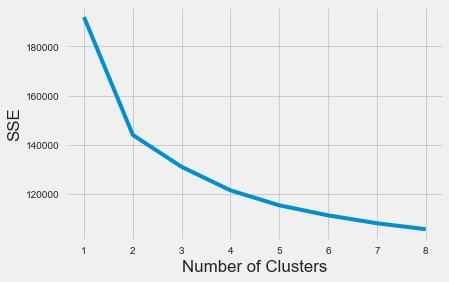

In [228]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 9), sse)
plt.xticks(range(1, 9))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [229]:
kl = KneeLocator(
    range(1, 9), sse, curve="convex", direction="decreasing"
)

kl.elbow

3

In [119]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_coefficients.append(score)

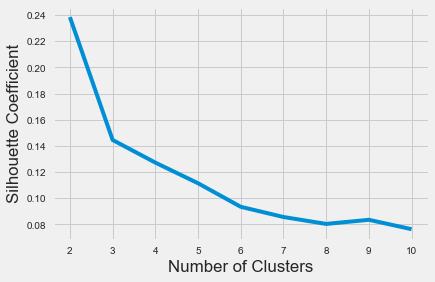

In [120]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

In [121]:
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score

In [122]:
features, true_labels = make_moons(
    n_samples=250, noise=0.05, random_state=42
)
scaled_features = scaler.fit_transform(features)

In [123]:
kmeans = KMeans(n_clusters=8)
dbscan = DBSCAN(eps=0.3)

# Fit the algorithms to the features
kmeans.fit(scaled_features)
dbscan.fit(scaled_features)

# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(
    scaled_features, kmeans.labels_
).round(2)
dbscan_silhouette = silhouette_score(
   scaled_features, dbscan.labels_
).round (2)

In [124]:
kmeans_silhouette

0.51

In [125]:
dbscan_silhouette

0.38

In [126]:
X.columns

Index(['mfcc1', 'mfcc2', 'mfcc6', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11',
       'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18',
       'mfcc20', 'rmse1', 'spectral_bandwidth1', 'spectral_centroid1',
       'spectral_rolloff1', 'zcr1', 'chroma_cens_avg', 'chroma_cqt_avg',
       'chroma_stft_avg', 'spectral_contrast_avg'],
      dtype='object')

In [127]:
# X = data[['chroma_cens_avg','chroma_cqt_avg', 'mfcc2', 'mfcc3', 'mfcc1', 'mfcc4', 'mfcc10', 'mfcc12', 'mfcc6',
#       'mfcc11', 'mfcc9', 'spectral_contrast_avg']]

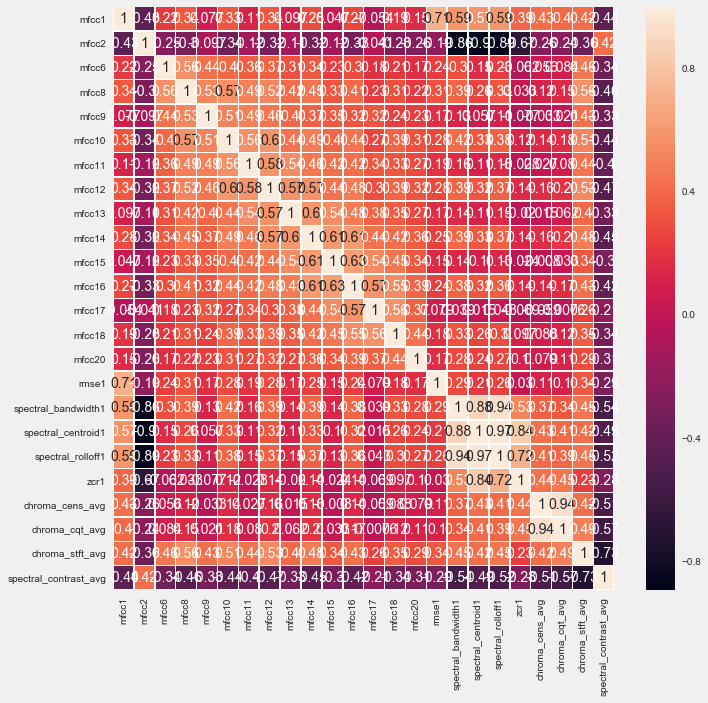

In [128]:

plt.figure(figsize=(10,10))
corr = X.corr()
sns.heatmap(corr, 
            xticklabels=X.columns.values,
            yticklabels=X.columns.values,
           annot=True,
           linewidth=0.5)
plt.savefig('audio_heatmap.png')

In [129]:
abs(corr) > 0.3

,mfcc1,mfcc2,mfcc6,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,...,mfcc20,rmse1,spectral_bandwidth1,spectral_centroid1,spectral_rolloff1,zcr1,chroma_cens_avg,chroma_cqt_avg,chroma_stft_avg,spectral_contrast_avg
mfcc1,True,True,False,True,False,True,False,True,False,False,...,False,True,True,True,True,True,True,True,True,True
mfcc2,True,True,False,False,False,True,False,True,False,True,...,False,False,True,True,True,True,False,False,True,True
mfcc6,False,False,True,True,True,True,True,True,True,True,...,False,False,True,False,False,False,False,False,True,True
mfcc8,True,False,True,True,True,True,True,True,True,True,...,False,True,True,False,True,False,False,False,True,True
mfcc9,False,False,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,True,True
mfcc10,True,True,True,True,True,True,True,True,True,True,...,True,False,True,True,True,False,False,False,True,True
mfcc11,False,False,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,True,True
mfcc12,True,True,True,True,True,True,True,True,True,True,...,True,False,True,True,True,False,False,False,True,True
mfcc13,False,False,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,True,True
mfcc14,False,True,True,True,True,True,True,True,True,True,...,True,False,True,True,True,False,False,False,True,True


In [133]:
# sns.lmplot(data=data_new, x="chroma_cens_avg", y="chroma_cqt_avg", hue="genre", palette='tab20',
#            fit_reg=False, legend=True, size=8, scatter_kws={'alpha':0.25, 's':12})
# plt.xlim(0,1.0)
# plt.ylim(0,1.0)
# plt.title("chroma_cens_avg vs. chroma_cqt_avg")
# #sns.set_palette('Set3', n_colors=n_genres)

In [134]:
# sns.lmplot(data=data, x="chroma_cens_avg", y="mfcc1", hue="genre", palette='tab20',
#            fit_reg=False, legend=True, size=8, scatter_kws={'alpha':0.25, 's':12})
# plt.xlim(0,1.0)
# plt.ylim(0,1.0)
# plt.title("chroma_cens_avg vs. mfcc1")
# #sns.set_palette('Set3', n_colors=n_genres)

In [135]:
X.columns

Index(['mfcc1', 'mfcc2', 'mfcc6', 'mfcc8', 'mfcc9', 'mfcc10', 'mfcc11',
       'mfcc12', 'mfcc13', 'mfcc14', 'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18',
       'mfcc20', 'rmse1', 'spectral_bandwidth1', 'spectral_centroid1',
       'spectral_rolloff1', 'zcr1', 'chroma_cens_avg', 'chroma_cqt_avg',
       'chroma_stft_avg', 'spectral_contrast_avg'],
      dtype='object')

7997
[0 1 2 3 4 5 6 7]
0.24946855070651494


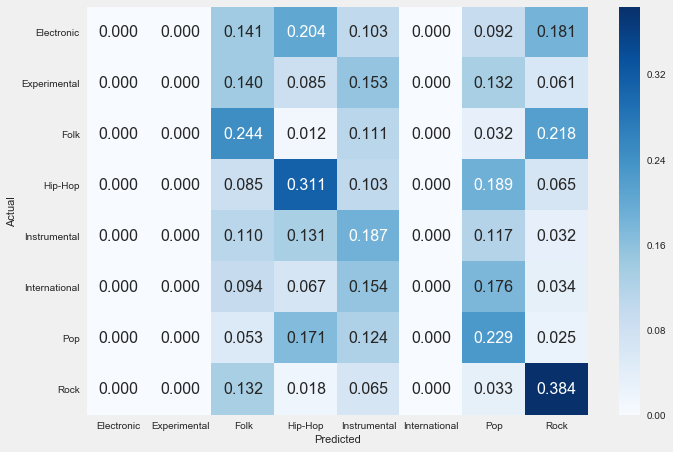

In [136]:
def find_permutation(n_clusters, real_labels, labels):
    permutation=[]
    for i in range(n_clusters):
        idx = labels == i
        new_label=scipy.stats.mode(real_labels[idx])[0][0] 
        permutation.append(new_label)
    return permutation

from sklearn.cluster import KMeans
import scipy
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
X_k = X

#X_k = data.drop(columns=['genre','title', 'track_id'])
print(len(X_k))
true_labels = data['genre']
len(true_labels)
scaler = StandardScaler()
scaler.fit(X_k)
X_scaled = scaler.transform(X_k)
clf = KMeans(n_clusters = 8, init='random')
clf.fit(X_k)
y_kmeans = clf.predict(X_k)
print(np.unique(clf.labels_))
permutation = find_permutation(8, true_labels, clf.labels_)
predicted_labels = [ permutation[label] for label in clf.labels_]
accuracy = accuracy_score(true_labels, predicted_labels)
print(accuracy)
labels = data.genre.unique()
confusion_mat_data = confusion_matrix(true_labels, predicted_labels, normalize='pred', labels = labels)
df_cm = pd.DataFrame(confusion_mat_data, columns=np.unique(true_labels), index = np.unique(true_labels))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},fmt = ".3f")

In [137]:
data_new.head()

,mfcc1,mfcc2,mfcc6,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,...,rmse1,spectral_bandwidth1,spectral_centroid1,spectral_rolloff1,zcr1,chroma_cens_avg,chroma_cqt_avg,chroma_stft_avg,spectral_contrast_avg,genre_factorised
0,-284.673103,136.940830,24.425244,12.865441,7.205975,-2.471064,9.460878,-5.984003,7.919311,-5.579881,...,1.968544,1389.195476,1270.517057,2571.502445,0.070002,0.271821,0.561447,0.497133,21.476695,0
1,-99.957216,100.856206,5.936942,1.743159,-9.087388,-0.618997,-6.614001,0.785494,-2.055657,-5.552616,...,6.808776,2437.100979,2230.693570,4486.854020,0.085219,0.243045,0.445526,0.397641,21.229311,1
2,-110.618921,89.579104,-21.095758,-8.071590,-12.867615,-1.811076,-5.459915,-1.675839,3.279005,-3.259410,...,5.291817,2368.194239,2284.877592,4382.598041,0.108170,0.246168,0.455258,0.240365,22.715981,1
3,-140.360722,107.095759,4.895010,0.294665,-12.860315,13.068435,-7.146124,2.789174,2.956712,3.124488,...,3.660768,2367.205362,1969.056499,4162.319868,0.074080,0.253937,0.491335,0.338472,22.937072,2
4,-383.205631,34.632317,-42.121712,39.805068,31.422007,11.054475,1.620559,0.774250,-13.686213,-10.400074,...,0.739969,2215.744376,2356.188217,4653.557040,0.100463,0.216975,0.362044,0.184751,23.291432,0


In [145]:
#classification data splitting 
X_train, X_test, Y_train, Y_test = train_test_split(data_new.iloc[:,:-1], data_new['genre_factorised'], test_size = 0.2, random_state=1)
#X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 1)
n_clusters = 8
clf = KMeans(n_clusters = n_clusters, random_state=42)
clf.fit(X_train)
y_labels_train = clf.labels_
y_labels_test = clf.predict(X_test)


In [165]:
clusters = clf.labels_

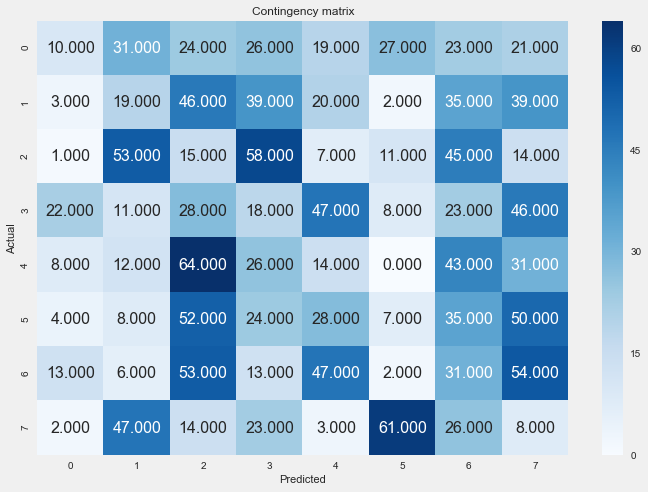

In [233]:
# Plot contingency matrix
cont_matrix = metrics.cluster.contingency_matrix(Y_test, y_labels_test)
plt.figure(figsize = (10,7))
sns.set(font_scale=1)
sns.heatmap(cont_matrix, cmap="Blues", annot=True,annot_kws={"size": 16},fmt = ".3f")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Contingency matrix')
plt.tight_layout()
# sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16},fmt = ".3f")

In [235]:
# Compute adjusted Rand index and silhouette coefficient
print(metrics.accuracy_score(Y_test, y_labels_test))

0.07625
